### Importing the Libraries


In [11]:
import cv2 as cv                                # OpenCV for image processing
import numpy as np                              # NumPy for numerical operations
import matplotlib.pyplot as plt                 # Matplotlib for plotting
from scipy.signal import butter, filtfilt       # SciPy for signal processing

### Accessing the Video

In [12]:
# The path to the video file
video_path = "/content/Heartbeat4.mp4"

# Load the video
cap = cv.VideoCapture(video_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Read the dimensions and properties of the video
fps = cap.get(cv.CAP_PROP_FPS)
height, width = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
print(f"FPS: {fps:.3f}, Total Frames: {frame_count}, Resolution: {width}x{height}")

FPS: 30.007, Total Frames: 323, Resolution: 392x848


### Extracting the PPG signals

In [13]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow  # 👈 Required for displaying images in Colab

# Initialize an empty list to store the PPG signal
ppg_signal = []

# Replace with your video path
video_path = "/content/Heartbeat4.mp4"
cap = cv.VideoCapture(video_path)

# Till the end of the video, read frames and extract PPG signal
while cap.isOpened():
    # Read a frame from the video
    ret, frame = cap.read()

    # If the frame was not read successfully, break the loop
    if not ret:
        break

    # Extract PPG signal from the red channel (OpenCV uses BGR)
    ppg_signal.append(np.mean(frame[:, :, 2]))

    # Display the current frame using cv2_imshow (for Colab)
    cv2_imshow(frame)

    # Add a short delay (note: waitKey is still needed even without GUI)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object
cap.release()
cv.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.

## Visualizing the Extracted Signals

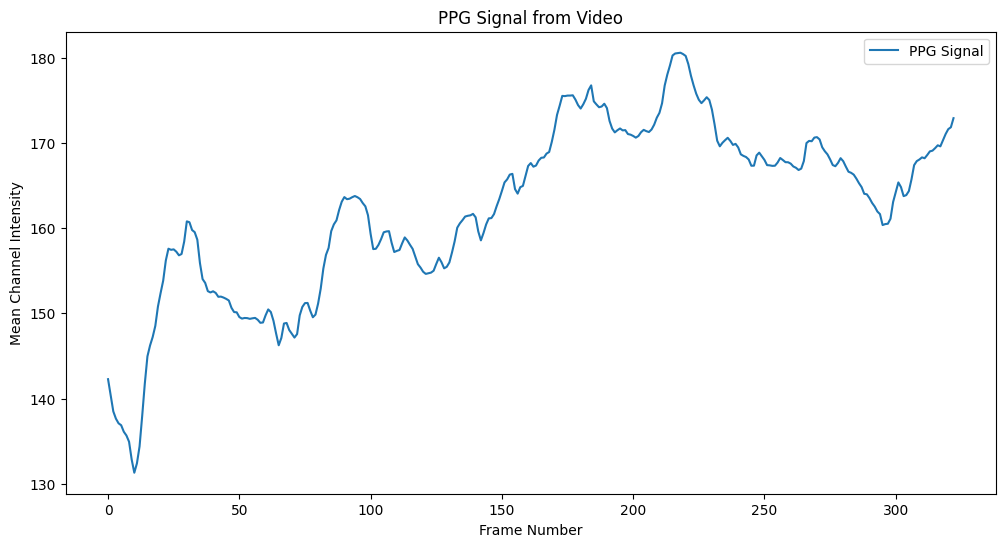

In [14]:
# Plot the PPG signal
plt.figure(figsize=(12, 6))
plt.plot(ppg_signal,label='PPG Signal')
plt.title('PPG Signal from Video')
plt.xlabel('Frame Number')
plt.ylabel('Mean Channel Intensity')
plt.legend()
plt.show()

## Filtering the Signals and visualizing the Results


In [15]:
# Function to apply a bandpass filter to the PPG signal
def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    """
    Apply a bandpass filter to the signal.
    Parameters:
    - signal: The input signal to be filtered.
    - lowcut: The lower cutoff frequency of the filter.
    - highcut: The upper cutoff frequency of the filter.
    - fs: The sampling frequency of the signal.
    - order: The order of the filter.
    Returns:
    - The filtered signal.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return filtfilt(b, a, signal)


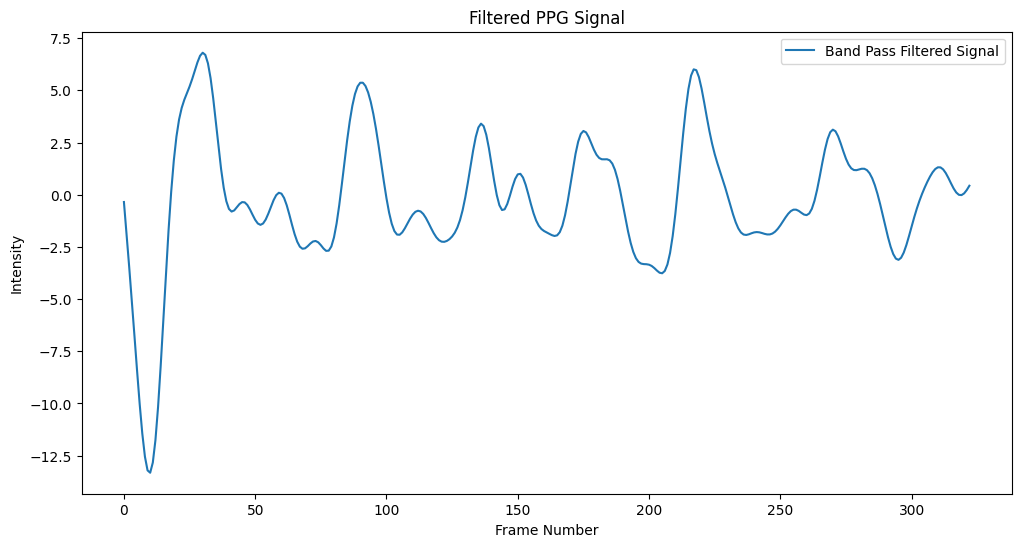

In [16]:
# Apply a bandpass filter to the PPG signal
plt.figure(figsize=(12, 6))
plt.plot(bandpass_filter(ppg_signal, lowcut=0.5, highcut=2.5, fs=30), label='Band Pass Filtered Signal')
plt.title('Filtered PPG Signal')
plt.xlabel('Frame Number')
plt.ylabel('Intensity')
plt.legend()
plt.show()

## Estimating Heart Rate PPG signal


### Peak Detection Algorithm

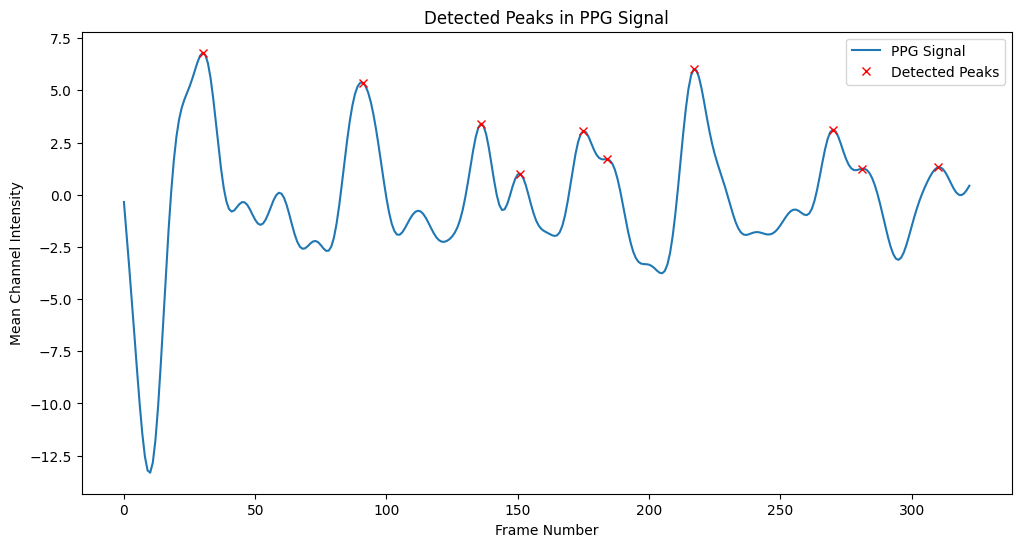

In [17]:
from scipy.signal import find_peaks


# Find peaks in the filtered PPG signal
filtered_signal = bandpass_filter(ppg_signal, lowcut=0.5, highcut=2.5, fs=30)
peaks, _ = find_peaks(filtered_signal, height=0.1, distance=5)


# Plot the PPG signal with detected peaks
plt.figure(figsize=(12, 6))
plt.plot(filtered_signal, label='PPG Signal')
plt.plot(peaks, np.array(filtered_signal)[peaks], "x", label='Detected Peaks', color='red')
plt.title('Detected Peaks in PPG Signal')
plt.xlabel('Frame Number')
plt.ylabel('Mean Channel Intensity')
plt.legend()
plt.show()

In [18]:
# Estimate heart rate from the detected peaks
peak_intervals = np.diff(peaks) / fps  # Convert frame intervals to seconds
heart_rate = 60 / np.mean(peak_intervals)  # Heart rate in beats per minute
print(f"Estimated Heart Rate: {heart_rate:.2f} Beats Per Minute")

Estimated Heart Rate: 57.87 Beats Per Minute


## Fourier Analysis

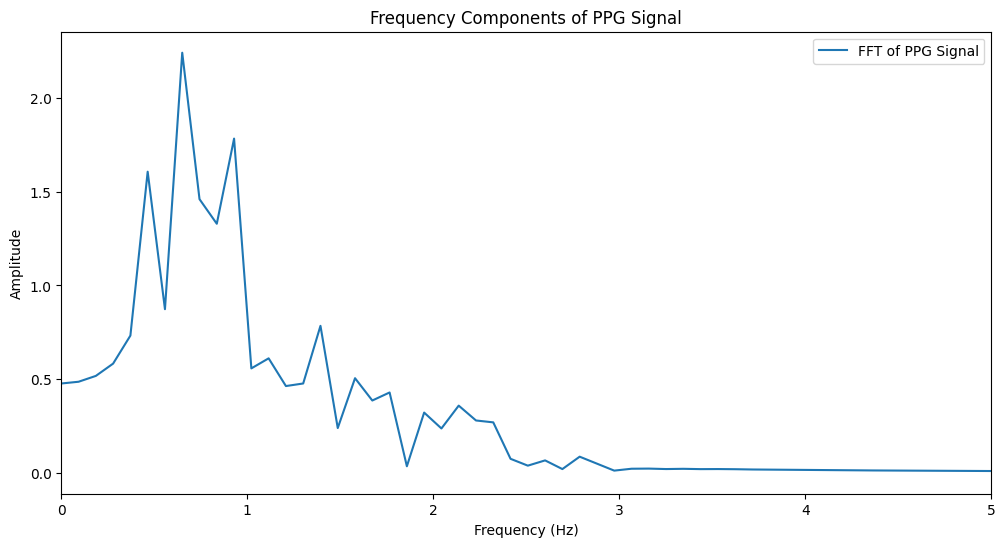

In [19]:
from scipy.fft import fft, fftfreq


# Compute the Fourier Transform of the PPG signal
N = len(filtered_signal)
T = 1 / fps  # Sampling interval
yf = fft(filtered_signal)
xf = fftfreq(N, T)[:N//2]  # Frequency bins


# Plot the Fourier Transform of the PPG signal
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='FFT of PPG Signal')
plt.title('Frequency Components of PPG Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 5)  # Limit x-axis to 5 Hz for better visibility
plt.legend()
plt.show()

In [20]:
# Estimate heart rate from the frequency domain
peak_freq = xf[np.argmax(2.0/N * np.abs(yf[:N//2]))]    # Frequency of the peak in the FFT
heart_rate_freq = peak_freq * 60                        # Convert frequency to beats per minute
print(f"Estimated Heart Rate from Frequency Domain: {heart_rate_freq:.2f} Beats Per Minute")

Estimated Heart Rate from Frequency Domain: 39.02 Beats Per Minute
